In [239]:
# evaluate mlp for monthly car sales dataset
from math import sqrt
import seaborn as sns
from numpy import array
from numpy import mean
from numpy import std
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from matplotlib.ticker import MultipleLocator
from keras.layers import Conv1D
from keras.layers import ConvLSTM2D
from keras.layers import MaxPooling1D
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import TimeDistributed
from statsmodels.tsa.stattools import adfuller
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np

In [240]:
def plot_y(variable):
    pyplot.figure(figsize = (10, 4))
    pyplot.plot(variable)
    pyplot.title("Temporal change of car sales")
    pyplot.xlabel('time')
    pyplot.xticks(rotation=45)
    pyplot.gca().xaxis.set_major_locator(MultipleLocator(5))
    pyplot.show();

In [241]:
# split a univariate dataset into train/test sets
def train_test_split(data, train_val_split_ratio):
    n_test = round(len(data)*(1 - train_val_split_ratio))
    return data[:-n_test], data[-n_test:]

In [242]:
# transform list into supervised learning format
def series_to_supervised(data, n_in, n_out=1):
    df = DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
    # drop rows with NaN values
    agg.dropna(inplace=True)
    return agg.values

In [243]:
def print_train_val_data(verbose = True):
    print("train data (raw) shape: ", train.shape)
    print("train data (processed) shape", data_train.shape)
    print("train data (processed) x shape: ", train_x.shape)
    print("train data (processed) y shape: ", train_y.shape)
    print("--------------------------------------------------------------------------")
    if(verbose):
        print("train data (raw) head: \n", train[0: 5])
        print("train data (processed) head: \n", data_train[0: 5])
        print("train data x (processed) head: \n", train_x[0: 5])
        print("train data y (processed) head: \n", train_y[0: 5])
        print("--------------------------------------------------------------------------")
    print("val data (raw) shape: ", val.shape)
    print("val data (processed) shape", data_val.shape)
    print("val data (processed) x shape: ", val_x.shape)
    print("val data (processed) y shape: ", val_y.shape)
    print("--------------------------------------------------------------------------")
    if(verbose):
        print("val data (raw) head: \n", val[0: 5])
        print("val data (processed) head: \n", data_val[0: 5])
        print("val data x (processed) head: \n", val_x[0: 5])
        print("val data y (processed) head: \n", val_y[0: 5])

In [244]:
def MLP(measure = "mse", optimizer = "adam"):
    # define model
    model = Sequential()
    model.add(Dense(n_nodes, activation = 'relu', input_dim = n_input))
    model.add(Dense(1))
    model.compile(loss = measure, optimizer = optimizer)

    return model

In [245]:
def CNN(measure = "mse", optimizer = "adam", n_filters = 256, n_kernel = 3):

    print("entering CNN")

    # define model
    model = Sequential()
    model.add(Conv1D(filters = n_filters, kernel_size = n_kernel, activation='relu', input_shape=(n_input, 1)))
    model.add(Conv1D(filters = n_filters, kernel_size = n_kernel, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(1))
    model.compile(loss = measure, optimizer = optimizer)

    print("leaving CNN")
    
    return model

In [246]:
def myLSTM(measure = "mse", optimizer = "adam"):
    print("entering LSTM")

    # define model
    model = Sequential()
    model.add(LSTM(n_nodes, activation='relu', input_shape=(n_input, 1)))
    model.add(Dropout(0.2))
    model.add(Dense(n_nodes, activation='relu'))
    model.add(Dense(1))
    model.compile(loss = measure, optimizer = optimizer)

    print("leaving LSTM")

    return model

In [247]:
def CnnLSTM(measure = "mse", optimizer = "adam"):
    print("entering CnnLSTM")

    # define model
    model = Sequential()
    model.add(TimeDistributed(Conv1D(filters=n_filters, kernel_size=n_kernel,
    activation='relu', input_shape=(None,n_steps,1))))
    model.add(TimeDistributed(Conv1D(filters=n_filters, kernel_size=n_kernel,
    activation='relu')))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(n_nodes, activation='relu'))
    model.add(Dense(n_nodes, activation='relu'))
    model.add(Dense(1))
    model.compile(loss = measure, optimizer = optimizer)

    print("leaving CnnLSTM")

    return model

In [248]:
def ConvLSTM(measure = "mse", optimizer = "adam"):
    print("entering ConvLSTM")

    # define model
    model = Sequential()
    model.add(ConvLSTM2D(filters = n_filters, kernel_size=(1, n_kernel), activation='relu',
    input_shape=(n_seq, 1, n_steps, 1)))
    model.add(Flatten())
    model.add(Dense(n_nodes, activation='relu'))
    model.add(Dense(1))
    model.compile(loss = measure, optimizer = optimizer)

    print("leaving ConvLSTM")

    return model

In [249]:
def data_reshape(train_x, val_x, model_name):
    if(model_name in ["CNN", "LSTM"]):
        train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], 1))
        val_x = val_x.reshape((val_x.shape[0], val_x.shape[1], 1))
    elif (model_name == "CnnLSTM"):
        train_x = train_x.reshape((train_x.shape[0], n_seq, n_steps, 1))
        val_x = val_x.reshape((val_x.shape[0], n_seq, n_steps, 1))
    elif (model_name == "ConvLSTM"):
        train_x = train_x.reshape((train_x.shape[0], n_seq, 1, n_steps, 1))
        val_x = val_x.reshape((val_x.shape[0], n_seq, 1, n_steps, 1))
    else:
        train_x = train_x
        val_x = val_x
    return train_x, val_x

In [250]:
# fit a model
def model_fit(train, val):
    # prepare data
    # training data
    data_train = series_to_supervised(train, n_input)
    train_x, train_y = data_train[:, :-1], data_train[:, -1]
    # validation data
    data_val = series_to_supervised(val, n_input)
    val_x, val_y = data_val[:, :-1], data_val[:, -1]

    ## reshape data
    train_x, val_x = data_reshape(train_x, val_x, model_name)
    
    # define model
    if(model_name == "CNN"):
        model = CNN(measure, optimizer, n_filters)
    elif (model_name == "MLP"):
        model = MLP(measure, optimizer)
    elif (model_name == "LSTM"):
        model = myLSTM(measure, optimizer)
    elif (model_name == "CnnLSTM"):
        model = CnnLSTM(measure, optimizer)
    elif (model_name == "ConvLSTM"):
        model = ConvLSTM(measure, optimizer)
    else:
        model = MLP(measure, optimizer)

    print("train x shape: ", train_x.shape)
    print("train y shape: ", train_y.shape)
    
    # fit
    history = model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, validation_data=(val_x, val_y), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)] if earlyStop else None, 
                    verbose=model_verbose, shuffle=False)
            
              
    return model, history

In [278]:
# forecast with a pre-fit model
def model_predict(model, history):
    # prepare data
    x_input = array(history[-n_input:]).reshape(1, n_input)
    # forecast
    yhat = model.predict(x_input, verbose=0)
 
    return yhat[0]

In [252]:
# visualize model loss
def plot_model_loss(history):
    '''
    For each train/test loss trajectory, plot loss by epoch
    '''
    pyplot.figure(figsize = (8, 4))
    pyplot.plot(history.history['loss'], label='Train Loss')
    pyplot.plot(history.history['val_loss'], label='Test Loss')
    pyplot.title("Model loss: {}".format(model_name))
    pyplot.ylabel('loss')
    pyplot.xlabel('epochs')
    pyplot.legend(loc='upper right')
    pyplot.show();

In [267]:
# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

In [339]:
# one-step simple forecast
def naive_average_forcast(history):
    # naive_n, offset, avg_type = config
    values = list()
    if offset == 1:
        values = history[-naive_n:]
    else:
        # skip bad configs
        if naive_n*offset > len(history):
            raise Exception('Config beyond end of data: %d %d' % (naive_n,offset))
        # try and collect n values using offset
        for i in range(1, naive_n+1):
            ix = i * offset
            values.append(history[-ix])
    # check if we can average
    if len(values) < 2:
        raise Exception('Cannot calculate average')
    # mean of last n values
    if avg_type == 'mean':
        return mean(values)
    # median of last n values
    return median(values)

In [340]:
# one-step simple forecast
def naive_persist_forcast(history):
    # n, offset, avg_type = config
    # persist value, ignore other config
    if avg_type == 'persist':
        return history[-naive_n]

In [334]:
# invert predictions
def invert_predict(val_predict, val_y):
    val_predict_scaler = scaler.inverse_transform(val_predict)
    val_y_scaler = scaler.inverse_transform([val_y])

    val_y_scaler_reshape = val_y_scaler.reshape((val_y_scaler.shape[1], 1))
    
    return val_y_scaler_reshape, val_predict_scaler

In [ ]:
def plot_actual_predict(val_predict_invert_scaler, val_y_invert_scaler):
    n = len(val_predict_scaler)
    aa=[x for x in range(n)]
    pyplot.figure(figsize=(8,4))
    pyplot.plot(aa, val_y_scaler_reshape[:n], marker='.', label="actual")
    pyplot.plot(aa, val_predict_scaler[:,0][:n], 'r', label="prediction")
    # plt.tick_params(left=False, labelleft=True) #remove ticks
    pyplot.tight_layout()
    sns.despine(top=True)
    pyplot.subplots_adjust(left=0.07)
    pyplot.ylabel('Energy demand', size=15)
    pyplot.xlabel('Time step', size=15)
    pyplot.legend(fontsize=15)
    pyplot.show();

In [336]:
def model_predict_list(model, history, measure):
    predictions = list()
    
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(val)):
        if(model_name not in ["naive_persist", "naive_average"]):
            # fit model and make forecast for history
            yhat = model_predict(model, history)
        elif (model_name == "naive_persist"):
            yhat = naive_persist_forcast(history)
        else:
            yhat = naive_average_forcast(history)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(val[i])

    # invert scalers
    val_y_invert_scaler, val_predict_invert_scaler = invert_predict(predictions, val)

    ## plot actual vs predicted
    plot_actual_predict(val_predict_invert_scaler, val_y_invert_scaler)

    # estimate prediction error
    error = float("inf")
    if(measure == "mse"):
        error = mean_squared_error(val_y_invert_scaler, val_predict_invert_scaler)
    elif(measure == "rmse"):
        error = measure_rmse(val_y_invert_scaler, val_predict_invert_scaler)
    elif(measure == "mae"):
         error = mean_absolute_error(val_y_invert_scaler, val_predict_invert_scaler)
    return error

In [269]:
# walk-forward validation for univariate data
def walk_forward_validation(data_normalize, train_val_split_ratio):
    # split dataset
    train, val = train_test_split(data_normalize, train_val_split_ratio)
    
    if(model_name not in ["naive_persist", "naive_average"]):
        # fit model
        model, historyRecord = model_fit(train, val)
        if(plot_loss):
            plot_model_loss(historyRecord)

    error = model_predict_list(model, historyRecord, measure)
    
    return model, historyRecord, error

In [294]:
# repeat evaluation of a config
def repeat_evaluate(data_normalize, train_val_split_ratio, n_repeats=30):
    # fit and evaluate the model n times
    scores = list()
    for i in range(n_repeats):
        _, _, score = walk_forward_validation(data_normalize, train_val_split_ratio)
        scores.append(score)
    return scores

#### Make predictions

In [230]:
series = read_csv('monthly-car-sales.csv', header=0, index_col=0)


In [231]:
series.head()

,Sales
Month,
1960-01,6550
1960-02,8728
1960-03,12026
1960-04,14395
1960-05,14587


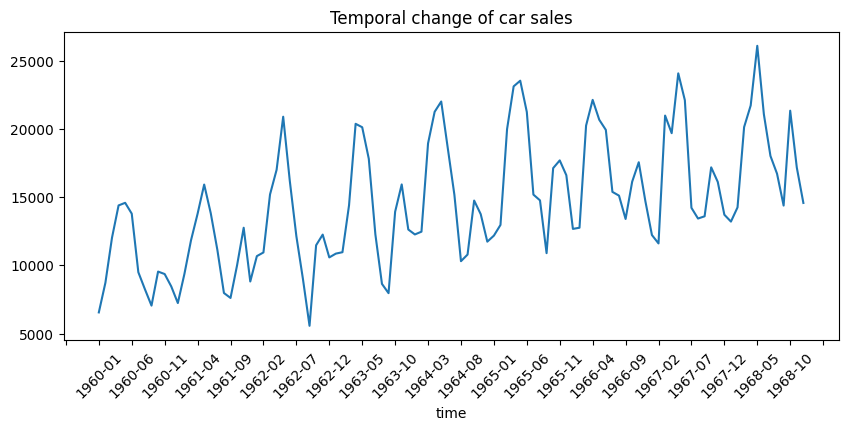

In [232]:
plot_y(series["Sales"])

In [233]:
def print_parameters():
    print("Model parameters:")
    print("series length (n_input): ", n_input)
    print("number of nodes (n_nodes): ", n_nodes)
    print("number of epochs (n_epochs): ", n_epochs)
    print("number of batches (n_batch): ", n_batch)
    print("earlyStop (earlyStop): ", earlyStop)
    print("measure (measure): ", measure)
    print("model_verbose (model_verbose): ", model_verbose)
    print("optimizer (optimizer): ", optimizer)
    print("model name (model_name): ", model_name)
    print("Number of filters (n_filters): ", n_filters)
    print("Number of kernels (n_kernel): ", n_kernel)
    print("Number of sequences (n_seq): ", n_seq)
    print("Number of steps (n_steps): ", n_steps)
    print("--------------------------------------------------------------------------")

In [234]:
# summarize model performance
def summarize_scores(name, scores):
    # print a summary
    scores_m, score_std = mean(scores), std(scores)
    print('%s: %.3f RMSE (+/- %.3f)' % (name, scores_m, score_std))
    # box and whisker plot
    pyplot.boxplot(scores)
    pyplot.show()

In [311]:
def data_normalize(dataset):
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset)
    return dataset, scaler

In [343]:
data = series.values

data_normalized, scaler = data_normalize(data)

# data split
train_val_split_ratio = 0.8

## Model name: naive_average, naive_persist, MLP, CNN, LSTM, CnnLSTM, ConvLSTM
model_name = "MLP"

## Naive models
naive_n = 1
offset = 1
avg_type = "mean"

# n_input: series length
n_input = 12
n_nodes = 500
n_epochs = 100
n_batch = 100
earlyStop = False
measure = "mse" 
model_verbose = 1
optimizer = "adam"
n_filters = 256
n_kernel = 3
n_seq = 2
plot_loss = True
n_steps = round(n_input/n_seq)

# split dataset into training and validation dataset
train, val = train_test_split(data_normalized, train_val_split_ratio)

# training data
data_train = series_to_supervised(train, n_input)
train_x, train_y = data_train[:, :-1], data_train[:, -1]

# validation data
data_val = series_to_supervised(val, n_input)
val_x, val_y = data_val[:, :-1], data_val[:, -1]

train_x, val_x = data_reshape(train_x, val_x, model_name)

print(print_parameters())

print(print_train_val_data(True))

Model parameters:
series length (n_input):  12
number of nodes (n_nodes):  500
number of epochs (n_epochs):  100
number of batches (n_batch):  100
earlyStop (earlyStop):  False
measure (measure):  mse
model_verbose (model_verbose):  1
optimizer (optimizer):  adam
model name (model_name):  MLP
Number of filters (n_filters):  256
Number of kernels (n_kernel):  3
Number of sequences (n_seq):  2
Number of steps (n_steps):  6
--------------------------------------------------------------------------
None
train data (raw) shape:  (86, 1)
train data (processed) shape (74, 13)
train data (processed) x shape:  (74, 12)
train data (processed) y shape:  (74,)
--------------------------------------------------------------------------
train data (raw) head: 
 [[0.04783011]
 [0.15391359]
 [0.31454873]
 [0.42993522]
 [0.43928693]]
train data (processed) head: 
 [[0.04783011 0.15391359 0.31454873 0.42993522 0.43928693 0.40051629
  0.19141786 0.13068043 0.07213482 0.19370708 0.18489114 0.14066534
  0.0

#### Train one time

train x shape:  (74, 12)
train y shape:  (74,)
Epoch 1/100
1/1 [==============================] - 1s 549ms/step - loss: 0.2029 - val_loss: 0.2529
Epoch 2/100
1/1 [==============================] - 0s 27ms/step - loss: 0.1272 - val_loss: 0.1453
Epoch 3/100
1/1 [==============================] - 0s 30ms/step - loss: 0.0753 - val_loss: 0.0783
Epoch 4/100
1/1 [==============================] - 0s 31ms/step - loss: 0.0464 - val_loss: 0.0481
Epoch 5/100
1/1 [==============================] - 0s 31ms/step - loss: 0.0377 - val_loss: 0.0449
Epoch 6/100
1/1 [==============================] - 0s 29ms/step - loss: 0.0428 - val_loss: 0.0546
Epoch 7/100
1/1 [==============================] - 0s 28ms/step - loss: 0.0529 - val_loss: 0.0639
Epoch 8/100
1/1 [==============================] - 0s 29ms/step - loss: 0.0603 - val_loss: 0.0661
Epoch 9/100
1/1 [==============================] - 0s 31ms/step - loss: 0.0617 - val_loss: 0.0606
Epoch 10/100
1/1 [==============================] - 0s 32ms/step - los

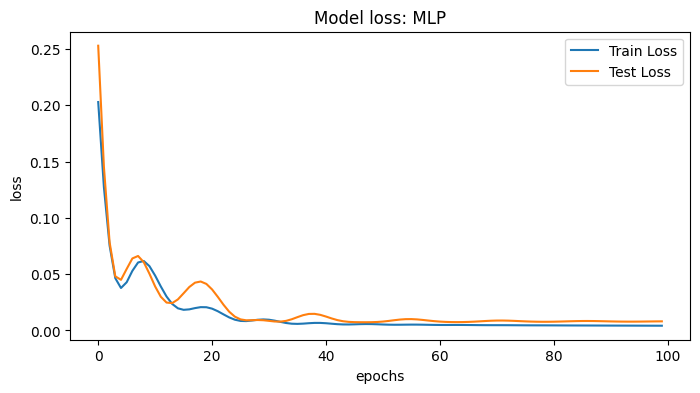

ValueError: Found array with dim 3. None expected <= 2.

In [344]:
# grid search
model, historyRecord, error = walk_forward_validation(data_normalized, train_val_split_ratio)

#### Train multiple times

In [325]:
model_verbose = 0
plot_loss = False
scores = repeat_evaluate(data_normalized, train_val_split_ratio, 5)

train x shape:  (74, 12)
train y shape:  (74,)
train x shape:  (74, 12)
train y shape:  (74,)
train x shape:  (74, 12)
train y shape:  (74,)
train x shape:  (74, 12)
train y shape:  (74,)
train x shape:  (74, 12)
train y shape:  (74,)


naive_average: 0.008 RMSE (+/- 0.000)


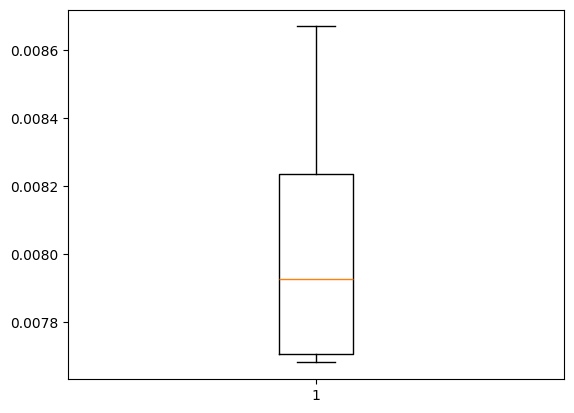

In [326]:
summarize_scores(model_name, scores)

#### Prediction

In [327]:
train_predict = model.predict(train_x)
val_predict = model.predict(val_x)

1/1 [==============================] - 0s 25ms/step


In [329]:
print('Train Mean Absolute Error:', mean_absolute_error(train_y_scaler_reshape, train_predict_scaler))
print('Train Root Mean Squared Error:', np.sqrt(mean_squared_error(train_y_scaler_reshape, train_predict_scaler)))
print('Test Mean Absolute Error:', mean_absolute_error(val_y_scaler_reshape, val_predict_scaler))
print('Test Root Mean Squared Error:', np.sqrt(mean_squared_error(val_y_scaler_reshape, val_predict_scaler)))

Train Mean Absolute Error: 1083.5408572635135
Train Root Mean Squared Error: 1352.3226073922967
Test Mean Absolute Error: 1547.4760742187495
Test Root Mean Squared Error: 1941.2475468028695


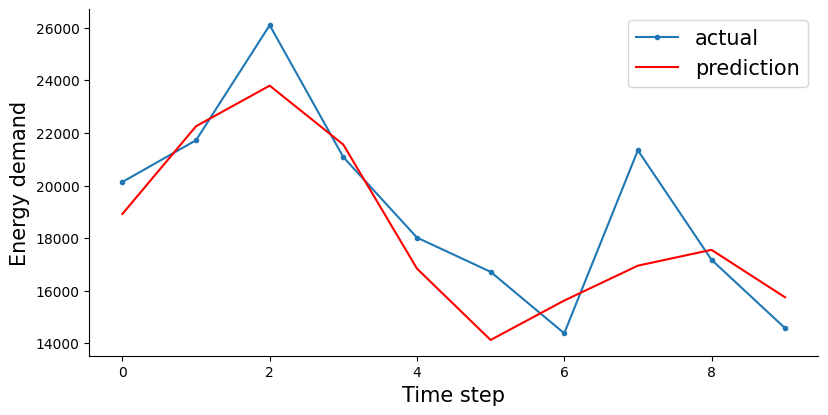

In [331]:
plot_actual_predict(val_predict_scaler, val_y_scaler_reshape)

In principle we do not need to check for stationarity nor correct for it when we are using an LSTM. However, if the data is stationary, it will help with better performance and make it easier for the neural network to learn.

### Dickey-Fuller Test to Ceck Stationarity

In statistics, the Dickey–Fuller test tests the null hypothesis that a unit root is present in an autoregressive model. The alternative hypothesis is different depending on which version of the test is used, but is usually stationarity or trend-stationarity.

Stationary series has constant mean and variance over time. Rolling average and the rolling standard deviation of time series do not change over time.

### Dickey-Fuller test

Null Hypothesis (H0): It suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.

Alternate Hypothesis (H1): It suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

p-value > 0.05: Accept the null hypothesis (H0), the data has a unit root and is non-stationary.

p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [25]:
def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window=30).mean()
    rolstd = timeseries.rolling(window=30).std()
    
    pyplot.figure(figsize=(14,5))
    sns.despine(left=True)
    orig = pyplot.plot(timeseries, color='blue',label='Original')
    mean = pyplot.plot(rolmean, color='red', label='Rolling Mean')
    std = pyplot.plot(rolstd, color='black', label = 'Rolling Std')

    pyplot.legend(loc='best'); pyplot.title('Rolling Mean & Standard Deviation')
    pyplot.xticks(rotation=45)
    pyplot.gca().xaxis.set_major_locator(MultipleLocator(5))
    pyplot.show()
    
    print ('<Results of Dickey-Fuller Test>')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

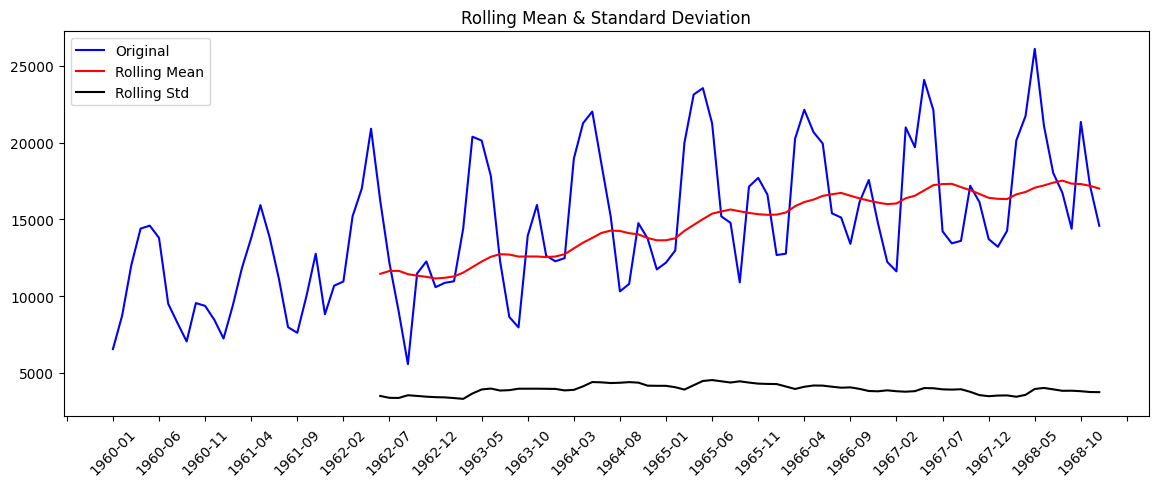

<Results of Dickey-Fuller Test>
Test Statistic                 -1.223813
p-value                         0.663269
#Lags Used                     12.000000
Number of Observations Used    95.000000
Critical Value (1%)            -3.501137
Critical Value (5%)            -2.892480
Critical Value (10%)           -2.583275
dtype: float64


In [26]:
test_stationarity(series)